<a href="https://colab.research.google.com/github/nyafein/Syntax_Semantics_Society/blob/main/Semantics_Syntax_Society.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nya Feinstein

Syntax, Semantics, and Society: Machine Learning Based Analysis of Linguistic Relativity

December 2024

In [ ]:
%%capture
! pip install --upgrade fileparser
! pip install sacremoses
! pip install transformers
! pip install sentence-transformers
!pip install umap-learn

In [ ]:
import json
import fileparser
import os
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
import numpy as np
import umap
from sacremoses import MosesTokenizer, MosesDetokenizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [ ]:
# Load data in
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Get the data
# TODO: Describe how I got the data, or make it so that anyone can put in their own
folder_path = '/content/drive/MyDrive/Fall 2024/DSCI 450/FINAL PROJECT/MAKED'

paths = []
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    paths.append(file_path)

In [ ]:
# Create Parsing Class

import os
class Parse:
    '''Intialize article json'''
    def __init__(self, article):
        self.article = article

    def get_title(self):
        try:
            return self.article['title']
        except:
            return []

    def get_date(self):
        try:
            return self.article['date']
        except:
            return []

    def get_url(self):
        try:
            return self.article['url']
        except:
            return []

    def get_summary(self):
        try:
            return self.article['summary']
        except:
            return []

    def get_text(self):
        '''Gets ALL the text in our article'''

        text = ''
        for element in self.article:
            # check subheading
            try:
                # subheading comes under a number so conversion to integer is possible
                int(element)

                text += ''.join(self.article[element]['para']) + '\n'

            except:
                pass

        return text

    def get_textall(self):
        "gets all the text , treats subheadings as a part of the text"
        text = ''
        for element in self.article:
            # check subheading
            try:
                # subhead or text comes under a number so conversion to integer is possible
                int(element)
                try:
                    text += self.article[element]['subheading'] + '\n'
                    text += ''.join(self.article[element]['para']) + '\n'
                except:
                    text += ''.join(self.article[element]['para']) + '\n'
            except:
                pass

        return text


    def get_subheading(self):
        'Returns a list all the subheadings'
        subheadings = []
        for element in self.article:
            try:
                int(element)
                if int(element) == 0:
                    pass
                else:
                    subheadings.append(self.article[element]['subheading'])

            except:
                pass

        return subheadings


    def get_images(self, path):
        'Returns a list of tuples of all image names inside our article along with their captions'
        images = []
        for element in self.article:
            try:
                int(element)
                if 'images' in self.article[element]:
                    images.extend(self.article[element]['images'])

            except:
                pass

        all_im = os.listdir(path)
        filter_images = []

        # Instead of checking like this, create a dictionary of article-images using this method and read image from that file directly

        for i in images:
            if i[0] in all_im and i not in filter_images:
                filter_images.append(i)


        return filter_images

    def get_keywords(self):
        'Returns a list of all keywords'
        try:
            return self.article['keyword']
        except:
            return []

    def get_related(self):
        'Returns a list of URLs all related articles'
        try:
            return self.article['related']
        except:
            return []

    def get_en_url(self):
        'Returns the parallel English URL for cross-lingual data'
        try:
            return self.article['english_url']
        except:
            return ''



In [ ]:
# Parse data (See github)

articles = []

for path in paths:

  # define the file_loader function
  def file_loader(path_to_file):
      # Loads a json file
      with open(path_to_file, encoding = 'utf-8') as f:
          data = json.load(f)
      return data

  # execute the file_loader function
  file = file_loader(path)

  # create an object of file using the Parse class
  article = Parse(file)
  articles.append(article)


In [ ]:
# All languages

language_unique = ["bengali","chinese","english","french","gujarati","hindi","indonesian",
             "japanese","marathi","nepali","pashto","portuguese","punjabi","russian",
             "sinhala","spanish","tamil","telegu","ukrainian","urdu"]

# Personally... I know that I downloaded 10 articles for each language, in this order

languages = []
for language in language_unique:
  for i in range(10):
    languages.append(language)

In [ ]:
# Gather summaries

summaries = []
for article in articles:
  summaries.append(article.get_summary())

In [ ]:
# Make a dataframe with the language and the summary

import pandas as pd

df = pd.DataFrame({
    'Language': languages,
    'Summary': summaries
})

display(df)

,Language,Summary
0,bengali,বাংলাদেশে বহুল আলোচিত পদ্মা সেতুর নির্মাণ কাজ ...
1,bengali,ভারতের কেরালায় শবরীমালা মন্দিরে মেয়েদের ঢুকত...
2,bengali,বাংলাদেশের কিশোরগঞ্জ শহরের নরসুন্দা নদীর তীরে ...
3,bengali,যে অপরাধে অন্য কোন দেশের বিরুদ্ধে যুক্তরাষ্ট্র...
4,bengali,ড. কামাল হোসেনের নেতৃত্বাধীন জাতীয় ঐক্যফ্রন্ট...
...,...,...
195,urdu,حکام کے مطابق پاکستان اور اس کے زیرِ انتظام کش...
196,urdu,پاکستان میں الیکٹرانک میڈیا کے نگراں ادارے پیم...
197,urdu,کسی بھی سرکاری ادارے کی طرح فوج میں بھی ترقی، ...
198,urdu,ایک طرف سعودی عرب کے 34 سالہ ولی عہد شہزادہ مح...


In [ ]:
# Token-level representation
embedder = pipeline("feature-extraction", model="DS-20202/debiasing_pre-trained_contextualised_embeddings_distil_bert", device=0)

# Step 2) Generate embeddings for each sentence
df['Embeddings'] = df['Summary'].apply(lambda x: embedder(x)[0][0])

# Step 3) Calculate cosine similarity for all embeddings
similarity_matrix = cosine_similarity(list(df['Embeddings']))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


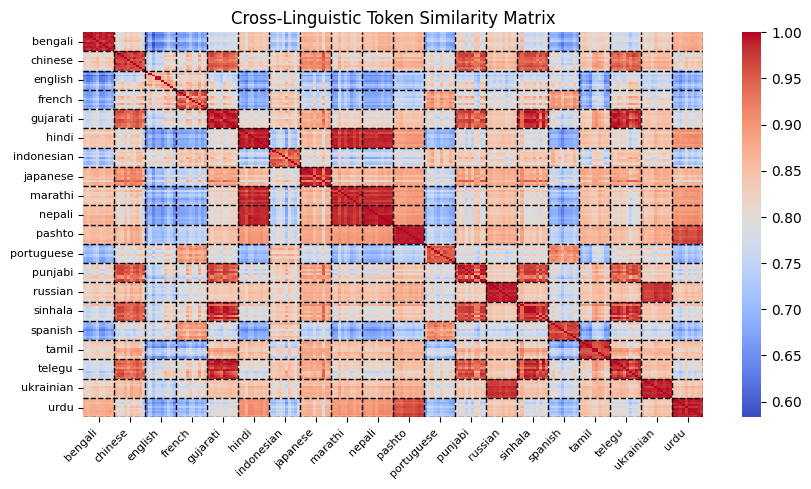

In [ ]:
# Heatmaps!
# 7. Create a heatmap of similarity scores for the WHOLE set
plt.figure(figsize=(10, 5))

tick_position = np.arange(5, 200, 10)

ax = sns.heatmap(similarity_matrix, annot=False, cmap="coolwarm",
                 xticklabels=language_unique, yticklabels=language_unique,
                 annot_kws={"size": 6})
plt.xticks(ticks = tick_position, labels = language_unique, rotation=45, ha='right', fontsize=8)
plt.yticks(ticks = tick_position, labels = language_unique, fontsize=8)
plt.title("Cross-Linguistic Token Similarity Matrix")

# Put 10x10 squares

tick_marks = np.linspace(10, 200, 20)

ax.hlines(tick_marks, *ax.get_xlim(), linestyle='dashed', linewidth=1, color="black")
ax.vlines(tick_marks, *ax.get_ylim(), linestyle='dashed', linewidth=1, color="black")


plt.show()

In [ ]:
# Sentence-level representation... This works a little better!

# Starting at Step 2: Generate embeddings for each sentence by averaging token embeddings (to get sentence-level representation)
df['Embeddings'] = df['Summary'].apply(lambda x: np.mean(embedder(x)[0], axis=0))

# Step 3: Calculate cosine similarity for all embeddings
embeddings_list_sentence = np.stack(df['Embeddings'].values)
similarity_matrix_sentence = cosine_similarity(embeddings_list_sentence)

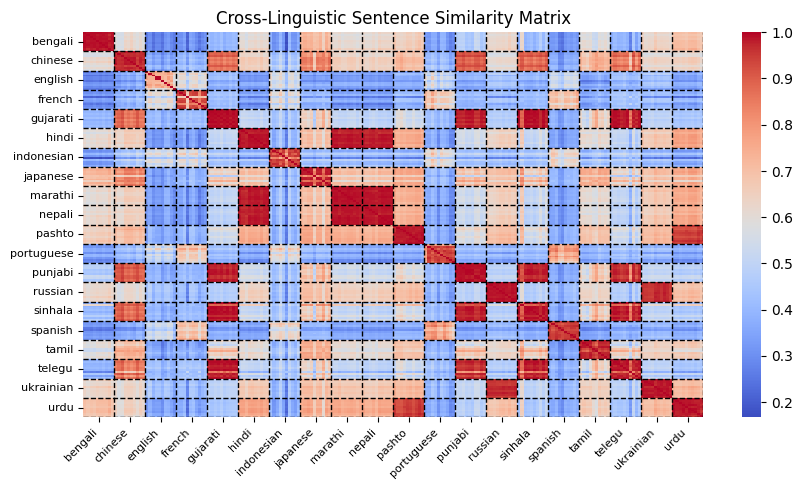

In [ ]:
# Heatmaps - with SENTENCES (to visualize)
# 7. Create a heatmap of similarity scores for the WHOLE set
plt.figure(figsize=(10, 5))

tick_position = np.arange(5, 200, 10)

ax = sns.heatmap(similarity_matrix_sentence, annot=False, cmap="coolwarm",
                 xticklabels=language_unique, yticklabels=language_unique,
                 annot_kws={"size": 6})
plt.xticks(ticks = tick_position, labels = language_unique, rotation=45, ha='right', fontsize=8)
plt.yticks(ticks = tick_position, labels = language_unique, fontsize=8)
plt.title("Cross-Linguistic Sentence Similarity Matrix")

# Put 10x10 squares

tick_marks = np.linspace(10, 200, 20)

ax.hlines(tick_marks, *ax.get_xlim(), linestyle='dashed', linewidth=1, color="black")
ax.vlines(tick_marks, *ax.get_ylim(), linestyle='dashed', linewidth=1, color="black")


plt.show()

In [ ]:
# Now, we're going to want to do some clustering. But, how many clusters do we need?

# Define the maximum number of clusters - the total number of languages we have
max_k = 20

# Dictionary to store silhouette scores for each of the cluster options
silhouette_scores = {}

# Step 1: Apply UMAP for dimensionality reduction
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=150, min_dist=0.5)
umap_embeddings = umap_reducer.fit_transform(np.stack(df['Embeddings']))

# Step 2: Scale the UMAP embeddings
scaler = StandardScaler()
umap_embeddings_scaled = scaler.fit_transform(umap_embeddings)

# Step 3: Loop through different values of k (2 to 20, which is the max)
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(umap_embeddings_scaled)
    score = silhouette_score(umap_embeddings_scaled, clusters)
    silhouette_scores[k] = score

# Get the max!
print(max(silhouette_scores, key=silhouette_scores.get))


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


10


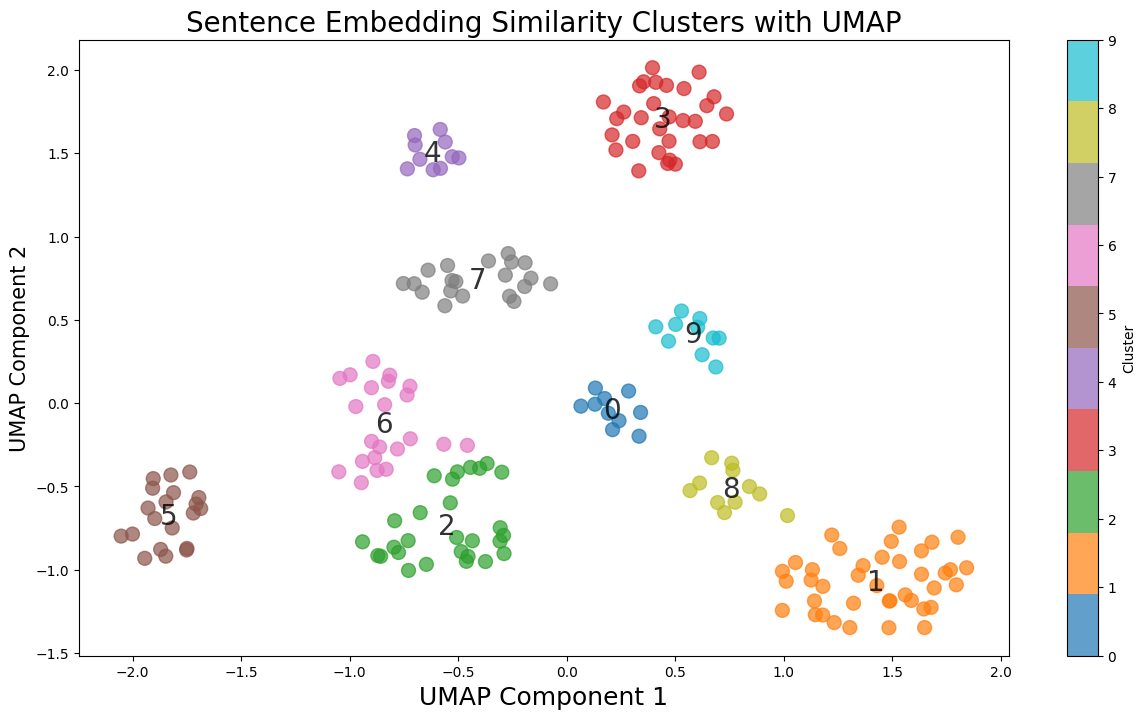

In [ ]:
# Let's visualize with UMAP and KMeans!
# Let's try with 10 clusters - that's the best, according to our test

# # Step 1: Apply UMAP with adjusted parameters
# umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=150, min_dist=0.5)
# umap_embeddings = umap_reducer.fit_transform(np.stack(df['Embeddings']))

# # Step 2: Optionally scale the UMAP embeddings for better spread
# scaler = StandardScaler()
# umap_embeddings_scaled = scaler.fit_transform(umap_embeddings)

# Step 3: Perform KMeans clustering
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(umap_embeddings_scaled)


# Step 4: Plot the scaled embeddings
plt.figure(figsize=(15, 8))
scatter = plt.scatter(umap_embeddings_scaled[:, 0], umap_embeddings_scaled[:, 1],
                      c=df['Cluster'], cmap="tab10", s=100, alpha=0.7)
plt.title("Sentence Embedding Similarity Clusters with UMAP", fontsize=20)
plt.xlabel("UMAP Component 1", fontsize=18)
plt.ylabel("UMAP Component 2", fontsize=15)
plt.colorbar(scatter, label="Cluster")

# Step 5: Calculate the centroid of each cluster and label it
for cluster_each in range(num_clusters):
    # Get the points of the current cluster
    cluster_points = umap_embeddings_scaled[df['Cluster'] == cluster_each]

    # Calculate the centroid of the cluster
    centroid = cluster_points.mean(axis=0)

    # Add the label at the centroid position
    plt.text(centroid[0], centroid[1], str(cluster_each), fontsize=20, color='black', ha='center', va='center', alpha=0.8)

plt.show()



In [ ]:
# Now, which languages are in there?

cluster_table = df.groupby('Cluster')['Language'].apply(list)

# Get the unique values
uniques = []
for i in range(len(cluster_table)):
    uniques_each = []
    for j in cluster_table[i]:
        if j not in uniques_each:
            uniques_each.append(j)
    uniques.append(uniques_each)

# Capitalize the languages
unique_cleaned = []
for i in uniques:
  cleans = []
  for j in i:
    j = j.capitalize()
    cleans.append(j)
  unique_cleaned.append(cleans)


cluster_df = pd.DataFrame({
    'Languages': unique_cleaned
})

display(cluster_df)

,Languages
0,[Japanese]
1,"[Gujarati, Punjabi, Sinhala, Telegu]"
2,"[French, Portuguese, Spanish]"
3,"[Hindi, Marathi, Nepali]"
4,[Bengali]
5,"[Russian, Ukrainian]"
6,"[English, French, Indonesian]"
7,"[Pashto, Urdu]"
8,"[Chinese, Sinhala]"
9,[Tamil]


In [ ]:
# Filter the DataFrame for languages in IndoEuropean list

df_filtered = df
df_filtered = df_filtered[['Language','Summary']]

IndoEuropean = ['russian', 'ukrainian','french','english','spanish','portuguese','sinhala','hindi','urdu','bengali','marathi','nepali','gujarati', 'punjabi', 'pashto']

df_filtered = df_filtered[df_filtered['Language'].isin(IndoEuropean)]

In [ ]:
# Sentence-level representation...

# Starting at Step 2: NOW generate embeddings for each sentence by averaging token embeddings (to get sentence-level representation)
df_filtered['Embeddings'] = df_filtered['Summary'].apply(lambda x: np.mean(embedder(x)[0], axis=0))

# Step 3: Calculate cosine similarity for all embeddings
embeddings_list_IE = np.stack(df_filtered['Embeddings'].values)
similarity_matrix_IE = cosine_similarity(embeddings_list_IE)

In [ ]:
import numpy as np

# Assuming 'similarity_matrix' is your 200x200 matrix

# Initialize an empty list to store sums of each 10x10 chunk
chunk_sums = []

# Define the size of each chunk (10x10)
chunk_size = 10

# Iterate through the matrix with a step size of 10 for both x and y axes
for i in range(0, similarity_matrix.shape[0], chunk_size):  # Loop through rows
    for j in range(0, similarity_matrix.shape[1], chunk_size):  # Loop through columns
        # Extract the 10x10 chunk
        chunk = similarity_matrix[i:i+chunk_size, j:j+chunk_size]
        # Sum all values in the chunk and append to chunk_sums
        chunk_sum = np.sum(chunk)
        chunk_sums.append(chunk_sum)

# Now, chunk_sums contains the sum of each 10x10 block
print(chunk_sums)


[98.84793968969352, 81.69143288871238, 66.56891098533082, 68.76175961036992, 77.49602423069784, 83.90224143140358, 73.33531195571223, 85.88147758774595, 83.67128882265685, 86.14378898162715, 85.81167605645622, 70.5442820310619, 80.6974751616721, 82.84310616755623, 78.23968573179052, 68.52672811380441, 81.90128182693438, 76.95281594429927, 82.43706419773407, 87.31038885168317, 81.6914328887124, 97.08105539984905, 78.25139808012133, 81.30403165344836, 93.92617218661826, 80.69102557066454, 83.05410743734488, 90.74744363363145, 81.93904138790904, 81.61415733662565, 85.98509933526825, 79.96548619024585, 94.63301497250812, 85.22322889975256, 94.95897883862278, 77.89194307038895, 84.94272851047144, 93.62669130919353, 85.46413969727169, 81.2421686087093, 66.56891098533082, 78.25139808012133, 86.88930780287592, 82.0357755803873, 77.01192186544635, 67.65903566475049, 80.23048487902186, 72.99651782721658, 69.43658538501002, 67.41026968142766, 72.13205094994875, 79.11854406102775, 77.1535880377037

In [ ]:
print(len(chunk_sums))

400


In [ ]:
# Assuming you have a list of 400 elements

chunk_matrix = np.array(chunk_sums).reshape(20, 20)

# Create a DataFrame from the reshaped data
chunk_df = pd.DataFrame(chunk_matrix)

chunk_df.columns = language_unique
chunk_df.index = language_unique

# Display the DataFrame
print(chunk_df)

              bengali    chinese    english     french   gujarati      hindi  \
bengali     98.847940  81.691433  66.568911  68.761760  77.496024  83.902241   
chinese     81.691433  97.081055  78.251398  81.304032  93.926172  80.691026   
english     66.568911  78.251398  86.889308  82.035776  77.011922  67.659036   
french      68.761760  81.304032  82.035776  94.500386  80.664632  68.874418   
gujarati    77.496024  93.926172  77.011922  80.664632  98.801216  80.062238   
hindi       83.902241  80.691026  67.659036  68.874418  80.062238  99.022805   
indonesian  73.335312  83.054107  80.230485  83.916637  82.963598  74.600596   
japanese    85.881478  90.747444  72.996518  77.110115  88.540032  84.978385   
marathi     83.671289  81.939041  69.436585  70.970126  81.659431  98.105159   
nepali      86.143789  81.614157  67.410270  68.552573  80.777333  98.432155   
pashto      85.811676  85.985099  72.132051  75.235511  84.701013  89.336568   
portuguese  70.544282  79.965486  79.118

In [ ]:

# Ensure that all values are numeric (in case they are stored as strings or objects)
chunk_df = chunk_df.apply(pd.to_numeric, errors='coerce')

# Function to get two greatest values and their row names for each column
def find_top_two(df):
    results = {}
    for col in df.columns:
        # Get the two highest values in the column
        top_two = df[col].nlargest(2)

        # Get the row names for these values
        top_two_rows = top_two.index.tolist()

        # Save the results: column name, two row names, and two values
        results[col] = {
            'values': top_two.tolist(),
            'rows': top_two_rows
        }
    return results

# Get the top two values and corresponding row names for each column
top_two_values = find_top_two(chunk_df)

# Display the results
for col, data in top_two_values.items():
    print(f"Column: {col}")
    print(f"Top two values: {data['values']}")
    print(f"Rows: {data['rows']}")
    print()


Column: bengali
Top two values: [98.84793968969352, 87.31038885168317]
Rows: ['bengali', 'urdu']

Column: chinese
Top two values: [97.08105539984905, 94.9589788386228]
Rows: ['chinese', 'sinhala']

Column: english
Top two values: [86.88930780287592, 82.03577558038727]
Rows: ['english', 'french']

Column: french
Top two values: [94.50038631450522, 88.74966605354427]
Rows: ['french', 'spanish']

Column: gujarati
Top two values: [98.80121587168756, 97.80135974607754]
Rows: ['gujarati', 'telegu']

Column: hindi
Top two values: [99.02280463569414, 98.43215454718998]
Rows: ['hindi', 'nepali']

Column: indonesian
Top two values: [94.49807089623556, 84.35772805656666]
Rows: ['indonesian', 'telegu']

Column: japanese
Top two values: [97.42825551048828, 90.74744363363145]
Rows: ['japanese', 'chinese']

Column: marathi
Top two values: [98.22333835127584, 98.10515938165909]
Rows: ['marathi', 'hindi']

Column: nepali
Top two values: [99.20162773867087, 98.43215454718998]
Rows: ['nepali', 'hindi']



In [ ]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# Sample Data (replace this with your similarity matrix)
languages = ["russian", "ukrainian", "french", "english", "spanish", "portuguese", "sinhala",
             "hindi", "urdu", "bengali", "marathi", "nepali", "gujarati", "punjabi", "pashto"]

# This is a similarity matrix you can work with
# (For now, let's create a dummy matrix for the sake of example)
similarity_matrix = np.random.rand(len(languages), len(languages))

# Convert to DataFrame for easier manipulation
df_similarity = pd.DataFrame(similarity_matrix, index=languages, columns=languages)

# We need to remove the diagonal elements as they represent self-similarity (100% similarity)
np.fill_diagonal(df_similarity.values, 0)

# Prepare the chord diagram data from the DataFrame
# Chord diagram requires "from" and "to" pairs and their corresponding values
edges = []
for i in range(len(languages)):
    for j in range(i + 1, len(languages)):  # Ensure pairs are not repeated
        edges.append({
            'from': languages[i],
            'to': languages[j],
            'value': df_similarity.iloc[i, j]
        })

# Chord diagram (plotly sunburst can also be used but for simplicity let's use Sankey style here)
chord_fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=languages
    ),
    link=dict(
        source=[languages.index(edge['from']) for edge in edges],
        target=[languages.index(edge['to']) for edge in edges],
        value=[edge['value'] for edge in edges]
    )
))

# Customize the layout of the diagram
chord_fig.update_layout(
    title="Language Pairwise Similarity Chord Diagram",
    font_size=10,
    width=800,
    height=600
)

# Show the chord diagram
chord_fig.show()
